# Load Dataset

In [1]:
import minari
import pickle
import numpy as np
import collections
import minari


def _load_dataset_minari(env_name, dataset = None): # jensk

    trajectories = dataset
    states, traj_lens, returns = [], [], []
    if 'pointmaze' in env_name :
        # re-label observation. (achieved_goal, desired_goal) -> observation
        print("re-label observation. (achieved_goal, desired_goal) -> observation")
        for path in trajectories :
            achieved_goal = path['observations']['achieved_goal'][1:]
            desired_goal = path['observations']['desired_goal'][1:]
            observation = np.concatenate([achieved_goal, desired_goal], axis=1)
            path['observations'] = observation

    for path in trajectories:
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
        # for pointmaze
    traj_lens, returns = np.array(traj_lens), np.array(returns)
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print(f"Average length: {np.mean(traj_lens):.2f}, std: {np.std(traj_lens):.2f}")
    print(f"Max length: {np.max(traj_lens):.2f}, min: {np.min(traj_lens):.2f}")
    print("=" * 50)

    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    trajectories = [trajectories[ii] for ii in sorted_inds]
    return trajectories, state_mean, state_std

def _load_dataset_01(env_name) :

    offline_trajs, state_mean, state_std = _load_dataset_minari(env_name, dataset)
    # create ['K'] length trajectories with initial state and final state
    offline_trajs_01 = []
    for traj in offline_trajs:
        traj_len = len(traj["observations"])
        # divide the trajectory into K length. get index of K length
        if traj_len < variant["K"] :
            continue 
        index = np.linspace(0, traj_len - 1, variant["K"]).astype(int)
        #print(f"traj len: {traj_len}, index : {index}")
        # get the state and action of the index
        # get the initial action and final action
        for key in traj.keys() :
            if key in ['id', 'total_timesteps', 'seed' ] :
                continue
            traj[key] = traj[key][index]
        offline_trajs_01.append(traj)
    
    print(f"offline_trajs_01 : {len(offline_trajs_01)}")
    return offline_trajs_01, state_mean, state_std
    
    


/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

env_name = "pointmaze-umaze-v1"
actual_env_name = 'PointMaze_Umaze-v3'
dataset = minari.load_dataset("pointmaze-umaze-v1")
dataset = dataset._data.get_episodes(range(0,1000))

variant = {}
variant['K'] = 20

data, state_mean, state_std = _load_dataset_01('pointmaze-umaze-v1')

re-label observation. (achieved_goal, desired_goal) -> observation
Starting new experiment: pointmaze-umaze-v1
1000 trajectories, 73537 timesteps found
Average return: 1.00, std: 0.00
Max return: 1.00, min: 1.00
Average length: 73.54, std: 43.50
Max length: 183.00, min: 1.00
offline_trajs_01 : 885


# Load Trained model01

In [3]:
from decision_transformer.models.decision_transformer import DecisionTransformer01
import torch
from pathlib import Path
import random
import numpy as np
MAX_EPISODE_LEN = 1000

variant = {
    "seed": 10,
    "env": "PointMaze_Umaze-v3",
    "K": 20,
    "embed_dim": 512,
    "n_layer": 4,
    "n_head": 4,
    "activation_function": "relu",
    "dropout": 0.1,
    "eval_context_length": 5,
    "ordering": 0,
    "eval_rtg": 3600,
    "num_eval_episodes": 10,
    "init_temperature": 0.1,
    "batch_size": 256,
    "learning_rate": 1e-4,
    "weight_decay": 5e-4,
    "warmup_steps": 10000,
    "max_pretrain_iters": 1,
    "num_updates_per_pretrain_iter": 5000,
    "max_online_iters": 1500,
    "online_rtg": 7200,
    "num_online_rollouts": 1,
    "replay_size": 1000,
    "num_updates_per_online_iter": 300,
    "eval_interval": 10,
    "device": "cuda",
    "log_to_tb": True,
    "save_dir": "./exp",
    "exp_name": "default",
    "tags": "model:01"
}

device = 'cuda'

model = DecisionTransformer01(
    state_dim= 4,
    state_range= [-2,2],
    max_length=variant["K"],
    eval_context_length=variant["eval_context_length"],
    max_ep_len=MAX_EPISODE_LEN,
    hidden_size=variant["embed_dim"],
    n_layer=variant["n_layer"],
    n_head=variant["n_head"],
    n_inner=4 * variant["embed_dim"],
    activation_function=variant["activation_function"],
    n_positions=1024,
    resid_pdrop=variant["dropout"],
    attn_pdrop=variant["dropout"],
    stochastic_policy=True,
    ordering=variant["ordering"],
    init_temperature=variant["init_temperature"],
    target_entropy= -4,
).to(device=device)


path_prefix = "./exp/2023.12.28/115859-default"
if Path(f"{path_prefix}/model.pt").exists():
    with open(f"{path_prefix}/model.pt", "rb") as f:
        checkpoint = torch.load(f)
    model.load_state_dict(checkpoint["model_state_dict"])
    #self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    #self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    #self.log_temperature_optimizer.load_state_dict(
    #    checkpoint["log_temperature_optimizer_state_dict"]
    #)
    #self.pretrain_iter = checkpoint["pretrain_iter"]
    #self.online_iter = checkpoint["online_iter"]
    #self.total_transitions_sampled = checkpoint["total_transitions_sampled"]
    np.random.set_state(checkpoint["np"])
    random.setstate(checkpoint["python"])
    torch.set_rng_state(checkpoint["pytorch"])
    print(f"Model loaded at {path_prefix}/model.pt")
#model.load_state_dict(torch.load('decision_transformer_01.pt'))

Model loaded at ./exp/2023.12.28/115859-default/model.pt


In [12]:


def convert_obs_type(obs, device) :
    # check obs batch size
    # handling (seq, state_dim) -> (1, seq, state_dim)
    if len(obs.shape) == 2 :
        obs = obs.reshape(1, -1, obs.shape[-1])
    elif len(obs.shape) == 1 :
        # handling (state_dim) -> (1, 1, state_dim)
        obs = obs.reshape(1, 1, obs.shape[-1])
    elif len(obs.shape) == 3 :
        # handling (batch_size, seq, state_dim) -> (batch_size, seq, state_dim)
        pass
    else :
        raise ValueError("obs shape is not valid")
    return torch.tensor(obs).float().to(device)

def regularize_obs(obs, model:DecisionTransformer01) :
    state_mean = 0
    state_std = 5
    obs = (obs - state_mean) / state_std
    return obs
def unregularize_obs(obs, model:DecisionTransformer01) :
    state_mean = 0
    state_std = 5
    obs = obs * state_std + state_mean
    return obs


def predict_K_sequence(batch_obs, model:DecisionTransformer01):
    # check model is where device. if model has no attribute device, check the first parameter of the model
    if hasattr(model, 'device') :
        device = model.device
    else :
        device = model.transformer.device
        
    obs = convert_obs_type(batch_obs, device)
    state_dim = obs.shape[-1]

    desired_goal = obs[:, -1, state_dim//2:]
    processed_obs = regularize_obs(obs, model)

    K = 5#model.max_length
    print(f"K : {K}")
    use_mean = True
    num_envs = 1
    print(f"state_dim : {state_dim}, desired_goal : {desired_goal}")
    while processed_obs.shape[1] < K :
        print(f'input : {processed_obs}')
        timesteps = torch.tensor([0] * 1, device=device, dtype=torch.long).reshape(1, -1).to(device)
        last_state_dist = model.get_predictions(processed_obs, timesteps)
        # the return action is a SquashNormal distribution
        state = last_state_dist.sample().reshape(1, -1, state_dim)[:, -1]
        if use_mean:
            state = last_state_dist.mean.reshape(num_envs, -1, state_dim)[:, -1]
        state = state.clamp(*model.state_range)
        state = convert_obs_type(state, device)
        # set desired_goal
        state[:,:, state_dim//2:] = desired_goal
        processed_obs = torch.cat([state,processed_obs], dim=1)
        timesteps += 1
    unregularized_obs = unregularize_obs(processed_obs, model)
    print(f"final result: obs: {unregularized_obs}")
    return unregularized_obs

batch_obs = data[2]['observations'][0]     
predict_K_sequence(batch_obs, model)



K : 5
state_dim : 4, desired_goal : tensor([[-0.8327,  0.8794]], device='cuda:0')
input : tensor([[[ 0.0376, -0.1869, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.0620, -0.2472, -0.8327,  0.8794],
         [ 0.0376, -0.1869, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.1448, -0.1909, -0.8327,  0.8794],
         [-0.0620, -0.2472, -0.8327,  0.8794],
         [ 0.0376, -0.1869, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.1555, -0.2412, -0.8327,  0.8794],
         [-0.1448, -0.1909, -0.8327,  0.8794],
         [-0.0620, -0.2472, -0.8327,  0.8794],
         [ 0.0376, -0.1869, -0.1665,  0.1759]]], device='cuda:0')
final result: obs: tensor([[[-0.7757, -0.8956, -4.1633,  4.3971],
         [-0.7777, -1.2058, -4.1633,  4.3971],
         [-0.7238, -0.9547, -4.1633,  4.3971],
         [-0.3101, -1.2360, -4.1633,  4.3971],
         [ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')


/tmp/ipykernel_23999/3906053130.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs).float().to(device)


tensor([[[-0.7757, -0.8956, -4.1633,  4.3971],
         [-0.7777, -1.2058, -4.1633,  4.3971],
         [-0.7238, -0.9547, -4.1633,  4.3971],
         [-0.3101, -1.2360, -4.1633,  4.3971],
         [ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')

885
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[0.8800, 0.7912]], device='cuda:0')
input : tensor([[[0.1744, 0.0694, 0.1760, 0.1582]]], device='cuda:0')
input : tensor([[[-0.0168,  0.0833,  0.8800,  0.7912],
         [ 0.1744,  0.0694,  0.1760,  0.1582]]], device='cuda:0')
input : tensor([[[ 0.0961,  0.1199,  0.8800,  0.7912],
         [-0.0168,  0.0833,  0.8800,  0.7912],
         [ 0.1744,  0.0694,  0.1760,  0.1582]]], device='cuda:0')
input : tensor([[[ 0.1088,  0.0606,  0.8800,  0.7912],
         [ 0.0961,  0.1199,  0.8800,  0.7912],
         [-0.0168,  0.0833,  0.8800,  0.7912],
         [ 0.1744,  0.0694,  0.1760,  0.1582]]], device='cuda:0')
final result: obs: tensor([[[-0.0338,  0.6291,  4.3999,  3.9559],
         [ 0.5442,  0.3032,  4.3999,  3.9559],
         [ 0.4806,  0.5997,  4.3999,  3.9559],
         [-0.0839,  0.4167,  4.3999,  3.9559],
         [ 0.8721,  0.3470,  0.8800,  0.7912]]], device='cuda:0')
(5, 2)


/tmp/ipykernel_23999/1293369811.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs).float().to(device)


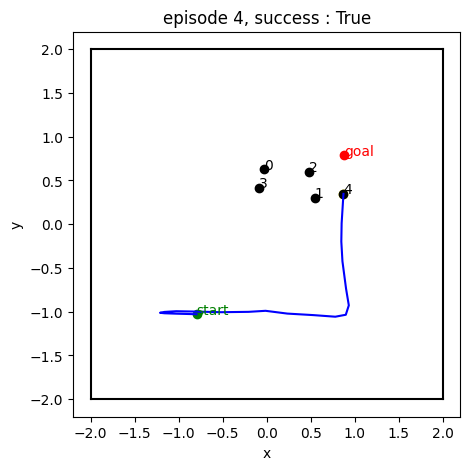

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[ 0.0923, -0.8737]], device='cuda:0')
input : tensor([[[ 0.1016, -0.1935,  0.0185, -0.1747]]], device='cuda:0')
input : tensor([[[ 0.0589, -0.2068,  0.0923, -0.8737],
         [ 0.1016, -0.1935,  0.0185, -0.1747]]], device='cuda:0')
input : tensor([[[ 0.0252, -0.2669,  0.0923, -0.8737],
         [ 0.0589, -0.2068,  0.0923, -0.8737],
         [ 0.1016, -0.1935,  0.0185, -0.1747]]], device='cuda:0')
input : tensor([[[ 0.0374, -0.2993,  0.0923, -0.8737],
         [ 0.0252, -0.2669,  0.0923, -0.8737],
         [ 0.0589, -0.2068,  0.0923, -0.8737],
         [ 0.1016, -0.1935,  0.0185, -0.1747]]], device='cuda:0')
final result: obs: tensor([[[ 0.2239, -1.2372,  0.4613, -4.3686],
         [ 0.1872, -1.4963,  0.4613, -4.3686],
         [ 0.1261, -1.3344,  0.4613, -4.3686],
         [ 0.2945, -1.0342,  0.4613, -4.3686],
         [ 0.5079, -0.9674,  0.0923, -0.8737]]], device='cuda:0')
(5, 2)


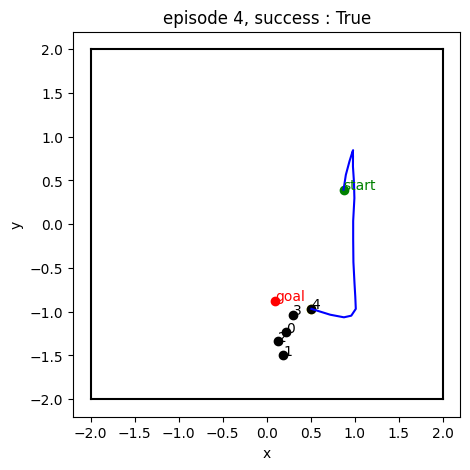

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[-0.8327,  0.8794]], device='cuda:0')
input : tensor([[[-0.0839,  0.1801, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.2188,  0.2176, -0.8327,  0.8794],
         [-0.0839,  0.1801, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.3024,  0.2056, -0.8327,  0.8794],
         [-0.2188,  0.2176, -0.8327,  0.8794],
         [-0.0839,  0.1801, -0.1665,  0.1759]]], device='cuda:0')
input : tensor([[[-0.2030,  0.2580, -0.8327,  0.8794],
         [-0.3024,  0.2056, -0.8327,  0.8794],
         [-0.2188,  0.2176, -0.8327,  0.8794],
         [-0.0839,  0.1801, -0.1665,  0.1759]]], device='cuda:0')
final result: obs: tensor([[[-1.2623,  1.0618, -4.1633,  4.3971],
         [-1.0151,  1.2902, -4.1633,  4.3971],
         [-1.5120,  1.0282, -4.1633,  4.3971],
         [-1.0942,  1.0882, -4.1633,  4.3971],
         [-0.4196,  0.9004, -0.8327,  0.8794]]], device='cuda:0')
(5, 2)


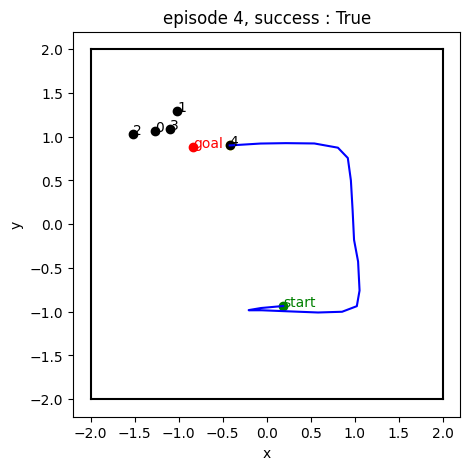

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[-0.0949, -0.8457]], device='cuda:0')
input : tensor([[[ 0.0636, -0.1894, -0.0190, -0.1691]]], device='cuda:0')
input : tensor([[[ 0.0128, -0.2142, -0.0949, -0.8457],
         [ 0.0636, -0.1894, -0.0190, -0.1691]]], device='cuda:0')
input : tensor([[[ 0.0334, -0.1663, -0.0949, -0.8457],
         [ 0.0128, -0.2142, -0.0949, -0.8457],
         [ 0.0636, -0.1894, -0.0190, -0.1691]]], device='cuda:0')
input : tensor([[[ 0.0021, -0.3125, -0.0949, -0.8457],
         [ 0.0334, -0.1663, -0.0949, -0.8457],
         [ 0.0128, -0.2142, -0.0949, -0.8457],
         [ 0.0636, -0.1894, -0.0190, -0.1691]]], device='cuda:0')
final result: obs: tensor([[[-0.3258, -1.6410, -0.4746, -4.2284],
         [ 0.0105, -1.5624, -0.4746, -4.2284],
         [ 0.1670, -0.8313, -0.4746, -4.2284],
         [ 0.0641, -1.0712, -0.4746, -4.2284],
         [ 0.3180, -0.9468, -0.0949, -0.8457]]], device='cuda:0')
(5, 2)


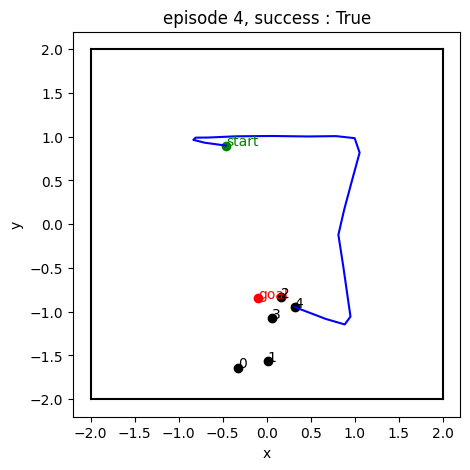

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[-0.7744,  0.7878]], device='cuda:0')
input : tensor([[[-0.0719,  0.1649, -0.1549,  0.1576]]], device='cuda:0')
input : tensor([[[-0.1445,  0.1978, -0.7744,  0.7878],
         [-0.0719,  0.1649, -0.1549,  0.1576]]], device='cuda:0')
input : tensor([[[-0.2327,  0.1847, -0.7744,  0.7878],
         [-0.1445,  0.1978, -0.7744,  0.7878],
         [-0.0719,  0.1649, -0.1549,  0.1576]]], device='cuda:0')
input : tensor([[[-0.2245,  0.0949, -0.7744,  0.7878],
         [-0.2327,  0.1847, -0.7744,  0.7878],
         [-0.1445,  0.1978, -0.7744,  0.7878],
         [-0.0719,  0.1649, -0.1549,  0.1576]]], device='cuda:0')
final result: obs: tensor([[[-1.6834,  0.9159, -3.8722,  3.9391],
         [-1.1225,  0.4744, -3.8722,  3.9391],
         [-1.1634,  0.9233, -3.8722,  3.9391],
         [-0.7225,  0.9892, -3.8722,  3.9391],
         [-0.3595,  0.8243, -0.7744,  0.7878]]], device='cuda:0')
(5, 2)


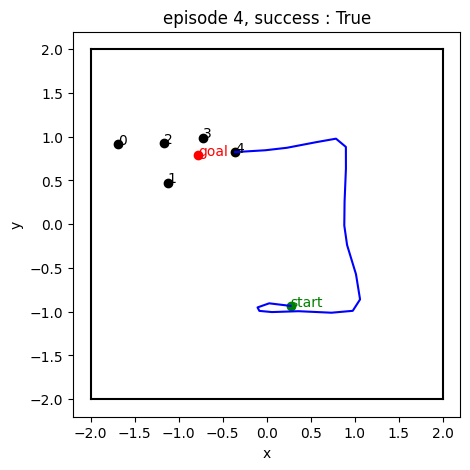

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[-0.0197, -1.0209]], device='cuda:0')
input : tensor([[[ 0.0839, -0.2119, -0.0039, -0.2042]]], device='cuda:0')
input : tensor([[[-0.1053, -0.3225, -0.0197, -1.0209],
         [ 0.0839, -0.2119, -0.0039, -0.2042]]], device='cuda:0')
input : tensor([[[-0.0704, -0.2907, -0.0197, -1.0209],
         [-0.1053, -0.3225, -0.0197, -1.0209],
         [ 0.0839, -0.2119, -0.0039, -0.2042]]], device='cuda:0')
input : tensor([[[-0.0550, -0.3129, -0.0197, -1.0209],
         [-0.0704, -0.2907, -0.0197, -1.0209],
         [-0.1053, -0.3225, -0.0197, -1.0209],
         [ 0.0839, -0.2119, -0.0039, -0.2042]]], device='cuda:0')
final result: obs: tensor([[[ 0.1623, -1.6996, -0.0985, -5.1045],
         [-0.2748, -1.5645, -0.0985, -5.1045],
         [-0.3522, -1.4535, -0.0985, -5.1045],
         [-0.5263, -1.6125, -0.0985, -5.1045],
         [ 0.4196, -1.0594, -0.0197, -1.0209]]], device='cuda:0')
(5, 2)


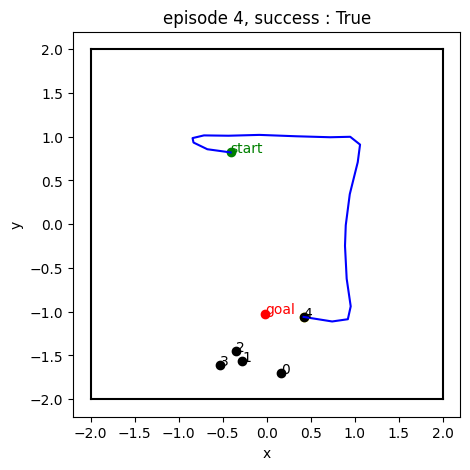

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[ 0.8142, -0.1207]], device='cuda:0')
input : tensor([[[ 0.2053, -0.0990,  0.1628, -0.0241]]], device='cuda:0')
input : tensor([[[ 0.1461, -0.0677,  0.8142, -0.1207],
         [ 0.2053, -0.0990,  0.1628, -0.0241]]], device='cuda:0')
input : tensor([[[ 0.1514, -0.1971,  0.8142, -0.1207],
         [ 0.1461, -0.0677,  0.8142, -0.1207],
         [ 0.2053, -0.0990,  0.1628, -0.0241]]], device='cuda:0')
input : tensor([[[ 0.0974, -0.1413,  0.8142, -0.1207],
         [ 0.1514, -0.1971,  0.8142, -0.1207],
         [ 0.1461, -0.0677,  0.8142, -0.1207],
         [ 0.2053, -0.0990,  0.1628, -0.0241]]], device='cuda:0')
final result: obs: tensor([[[ 0.8976, -0.6336,  4.0712, -0.6035],
         [ 0.4872, -0.7063,  4.0712, -0.6035],
         [ 0.7570, -0.9855,  4.0712, -0.6035],
         [ 0.7305, -0.3386,  4.0712, -0.6035],
         [ 1.0267, -0.4950,  0.8142, -0.1207]]], device='cuda:0')
(5, 2)


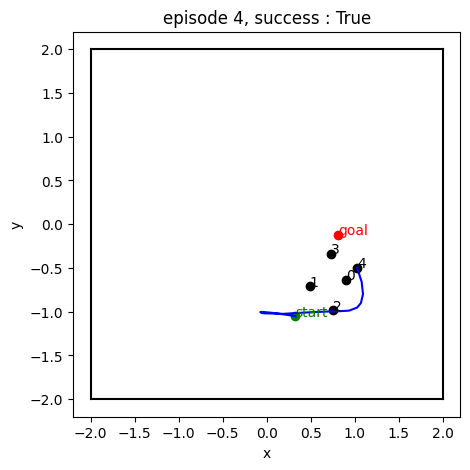

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[ 1.0984, -1.2471]], device='cuda:0')
input : tensor([[[ 0.1994, -0.1679,  0.2197, -0.2494]]], device='cuda:0')
input : tensor([[[ 0.1731, -0.1991,  1.0984, -1.2471],
         [ 0.1994, -0.1679,  0.2197, -0.2494]]], device='cuda:0')
input : tensor([[[ 0.1376, -0.2040,  1.0984, -1.2471],
         [ 0.1731, -0.1991,  1.0984, -1.2471],
         [ 0.1994, -0.1679,  0.2197, -0.2494]]], device='cuda:0')
input : tensor([[[ 0.0592, -0.2418,  1.0984, -1.2471],
         [ 0.1376, -0.2040,  1.0984, -1.2471],
         [ 0.1731, -0.1991,  1.0984, -1.2471],
         [ 0.1994, -0.1679,  0.2197, -0.2494]]], device='cuda:0')
final result: obs: tensor([[[ 0.9742, -1.1027,  5.4919, -6.2354],
         [ 0.2961, -1.2092,  5.4919, -6.2354],
         [ 0.6882, -1.0202,  5.4919, -6.2354],
         [ 0.8656, -0.9954,  5.4919, -6.2354],
         [ 0.9972, -0.8397,  1.0984, -1.2471]]], device='cuda:0')
(5, 2)


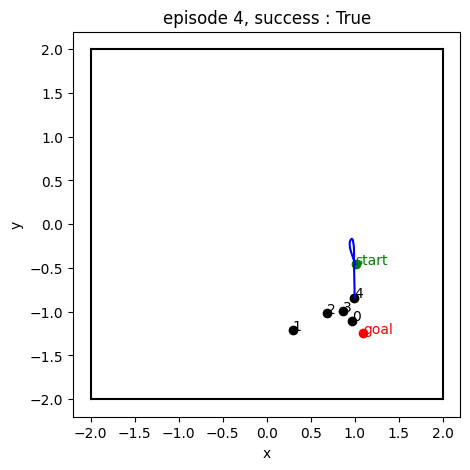

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[-0.8799, -1.0690]], device='cuda:0')
input : tensor([[[-0.0938, -0.2107, -0.1760, -0.2138]]], device='cuda:0')
input : tensor([[[-0.1885, -0.2913, -0.8799, -1.0690],
         [-0.0938, -0.2107, -0.1760, -0.2138]]], device='cuda:0')
input : tensor([[[-0.3160, -0.3793, -0.8799, -1.0690],
         [-0.1885, -0.2913, -0.8799, -1.0690],
         [-0.0938, -0.2107, -0.1760, -0.2138]]], device='cuda:0')
input : tensor([[[-0.2616, -0.3425, -0.8799, -1.0690],
         [-0.3160, -0.3793, -0.8799, -1.0690],
         [-0.1885, -0.2913, -0.8799, -1.0690],
         [-0.0938, -0.2107, -0.1760, -0.2138]]], device='cuda:0')
final result: obs: tensor([[[-0.9842, -1.6300, -4.3995, -5.3449],
         [-1.3082, -1.7127, -4.3995, -5.3449],
         [-1.5802, -1.8964, -4.3995, -5.3449],
         [-0.9427, -1.4565, -4.3995, -5.3449],
         [-0.4689, -1.0533, -0.8799, -1.0690]]], device='cuda:0')
(5, 2)


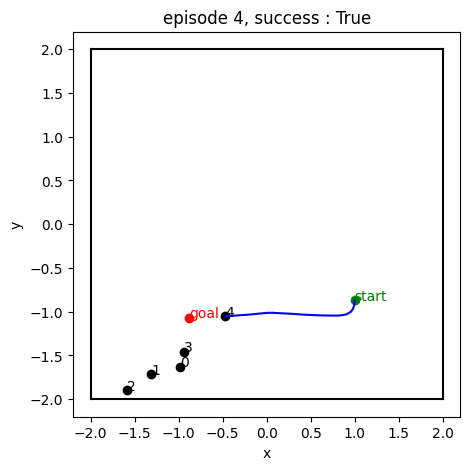

episode done at 4
(20, 4)
K : 5
state_dim : 4, desired_goal : tensor([[1.0759, 1.1415]], device='cuda:0')
input : tensor([[[0.2095, 0.1440, 0.2152, 0.2283]]], device='cuda:0')
input : tensor([[[0.2445, 0.2298, 1.0759, 1.1415],
         [0.2095, 0.1440, 0.2152, 0.2283]]], device='cuda:0')
input : tensor([[[0.1288, 0.1545, 1.0759, 1.1415],
         [0.2445, 0.2298, 1.0759, 1.1415],
         [0.2095, 0.1440, 0.2152, 0.2283]]], device='cuda:0')
input : tensor([[[0.1182, 0.1479, 1.0759, 1.1415],
         [0.1288, 0.1545, 1.0759, 1.1415],
         [0.2445, 0.2298, 1.0759, 1.1415],
         [0.2095, 0.1440, 0.2152, 0.2283]]], device='cuda:0')
final result: obs: tensor([[[0.7426, 1.1768, 5.3794, 5.7073],
         [0.5909, 0.7393, 5.3794, 5.7073],
         [0.6441, 0.7727, 5.3794, 5.7073],
         [1.2224, 1.1492, 5.3794, 5.7073],
         [1.0475, 0.7198, 1.0759, 1.1415]]], device='cuda:0')
(5, 2)


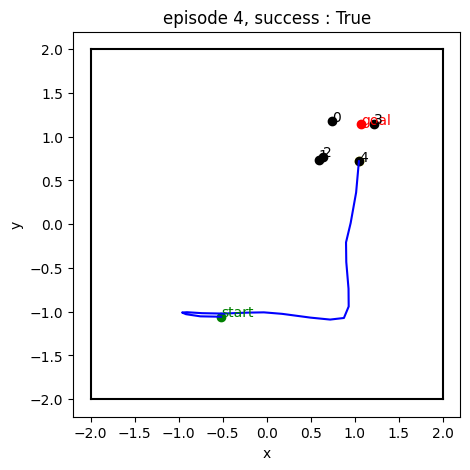

episode done at 4


In [11]:
# plot map with matplotlib
import matplotlib.pyplot as plt

map_size = ((-2,2),(-2,2)) # x, y


def init_figure() :
    # draw outline 
    plt.figure(figsize=(5,5))
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][0], map_size[1][0]], color='black')
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][1], map_size[1][1]], color='black')
    plt.plot([map_size[0][0], map_size[0][0]], [map_size[1][0], map_size[1][1]], color='black')
    plt.plot([map_size[0][1], map_size[0][1]], [map_size[1][0], map_size[1][1]], color='black')
    # set figure size


def plot_trajectory(trajectory, color='blue'):
    # plot trajectory
    plt.plot(trajectory[:,0], trajectory[:,1], color=color)

start_i = 0
n_epi = 10
episode_frames = []
episode_agent_states = []
episode_goals = []
episode_start = start_i
episode_done = False

print(len(data))
for i in range (start_i, start_i + n_epi) :
    achieved_goal = data[i]['observations'][:,:2]
    desired_goals = data[i]['observations'][:,-2:]
    print(data[i]['observations'].shape)
    # predict K sequence
    model01_input = data[i]['observations'][-1]
    model01_output = predict_K_sequence(model01_input, model).detach().cpu().numpy()
    # reshape model01_output, crop only achived_goal
    model01_output = model01_output[:, :, :2]
    model01_output = model01_output.reshape(-1, 2)
    print(model01_output.shape)
    
    
    # draw trajectory
    init_figure()
    plot_trajectory(np.array(achieved_goal))
    # draw goals
    plt.scatter(desired_goals[-1][0], desired_goals[-1][1], color='red')
    # draw start
    plt.scatter(achieved_goal[0][0], achieved_goal[0][1], color='green')
    # draw end
    plt.scatter(achieved_goal[-1][0], achieved_goal[-1][1], color='yellow')
    # add labels that show what meaning of green, yellow, red
    plt.text(achieved_goal[0][0], achieved_goal[0][1], 'start', color='green')
    #plt.text(episode_agent_states[-1][0], episode_agent_states[-1][1], 'end', color='yellow')
    plt.text(desired_goals[-1][0], desired_goals[-1][1], 'goal', color='red')
    
    # scatter model01_output
    for i in range(len(model01_output)) :
        plt.scatter(model01_output[i][0], model01_output[i][1], color='black')
        plt.text(model01_output[i][0], model01_output[i][1], f'{i}', color='black')
    
    plt.title(f'episode {i}, success : {data[i]["rewards"].any()}')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()
    episode_agent_states = []
    episode_goals = []
    episode_done = False
    print('episode done at', i)


In [6]:
data[0]['observations'].shape

(20, 4)